In [87]:
import pandas as pd
import numpy as np
import panel as pn
pn.extension('tabulator')

import hvplot.pandas

In [88]:
# !panel serve renewable_dashboard.ipynb --allow-websocket-origin=*

## (0) Preprocessing

In [89]:
df = pd.read_csv(r'C:\Users\Дарья\Desktop\projects\data\renewable-share-energy.csv', usecols=['Entity', 'Year', "Renewables (% equivalent primary energy)"])

In [90]:
df.columns = ['country', 'year', 'renewables']

In [91]:
for i in range(df['country'].size):
    el = df.loc[i, 'country']
    p = el.find('(BP)')
    if p >= 0:               
        el = el[:p-1]+el[p+5:]
        df.loc[i, 'country'] = el

In [92]:
unique_values = df['country'].unique()

In [93]:
continents = np.array(['Asia', 'Africa', 'North America', 'South America', 'Antarctica', 'Europe', 'Australia'])
regions = np.array(['Europe', 'North America', 'Central America', 'South America', 'Eastern Africa', 'Middle Africa', 'South Africa', 'Western Africa', 'Middle East', 'Oceania', 'Asia Pacific'])
income_classes = np.array(['Lower-middle-income countries', 'Upper-middle-income countries', 'High-income countries'])
unions = np.array(['European Union (27)', 'CIS'])
by_OECD = np.array(['OECD', 'Non-OECD'])

In [94]:
countries = [el for el in unique_values if not any(el in x for x in continents)]
countries = [el for el in countries if not any(el in x for x in regions)]
countries = [el for el in countries if not any(el in x for x in by_OECD)]
countries = [el for el in countries if not any(el in x for x in income_classes)]
countries = [el for el in countries if not any(el in x for x in unions)]
countries.remove('World')
countries.remove('South and Central America')
countries = np.array(countries)

In [95]:
df = df.fillna(0)

In [96]:
(df['year'].min(),
df['year'].max())

(1965, 2021)

In [97]:
idf = df.interactive()

## (1) Renewables (percent) over time by continents

In [98]:
## Define panel widgets
year_slider = pn.widgets.IntSlider(name='Year slider', start=1965, end=2021, step=1, value=2018)

In [99]:
renewables_per_continents_pipeline = (
    idf[
        (idf['year']<=year_slider)&
        (idf['country'].isin(continents))
         ]
    .groupby(['country', 'year'])['renewables'].mean()
    .to_frame()
    .reset_index()
    .sort_values('year')
    .reset_index(drop=True)
)

renewables_per_continents_plot = renewables_per_continents_pipeline.hvplot(x='year', by='country', y='renewables', ylabel='renewables percent', clabel='continent', line_width=2, title='Percent of renewable energy by continents')

## Table

In [100]:
renewables_per_region_pipeline = (
    idf[
    (idf['year']==year_slider)&
    (idf['country'].isin(regions))
    ]
    .groupby(['country', 'year'])['renewables'].mean()
    .to_frame()
    .reset_index()
    .sort_values('renewables', ascending=False)
    .reset_index(drop=True)
)
renewables_per_region_table = renewables_per_region_pipeline.pipe(pn.widgets.Tabulator, pagination='remote', page_size=10, sizing_mode='stretch_width')

## Bar plot

In [101]:
renewablws_per_country_bar_plot_pipeline = (
    idf[
        (idf['year']==year_slider)&
        (idf['country'].isin(countries))
    ]
    .groupby(['country', 'year'])['renewables'].mean()
    .to_frame()
    .reset_index()
    .sort_values(['year', 'renewables'], ascending=False)
    .reset_index(drop=True)
)

renewablws_per_country_bar_plot = renewablws_per_country_bar_plot_pipeline.hvplot(kind='bar', x='country',xlabel='', ylabel='percent renewables', y='renewables', title='Renewables by countries', rot=65, width=1100)

In [102]:
hvplot.help('bar')


A vertical bar plot

A `bar` plot represents categorical data with rectangular bars
with heights proportional to the values that they represent. The x-axis
plots categories and the y axis represents the value scale.
The bars are of equal width which allows for instant comparison of data.

`bar` can be used on dataframes with regular Index or MultiIndex.

Reference: https://hvplot.holoviz.org/reference/pandas/bar.html

Parameters
----------
x : string, optional
    Field name to draw x-positions from. If not specified, the index is used.
y : string, optional
    Field name to draw y-positions from. If not specified, all numerical
    fields are used.
stacked : bool, optional
    If True, creates a stacked bar plot. Default is False.
color : str or array-like, optional.
    The color for each of the series. Possible values are:

    A single color string referred to by name, RGB or RGBA code, for instance 'red' or
    '#a98d19'.

    A sequence of color strings referred to by name, RGB 

## Dashboard

FastListTemplate
    [js_area] HTML(None, height=0, margin=0, sizing_mode='fixed', width=0)
    [actions] TemplateActions()
    [busy_indicator] LoadingSpinner(height=20, width=20)
    [3019064538304] Row(margin=(0, 25))
        [0] ParamFunction(function, _pane=Tabulator, width=300)
        [1] ParamFunction(function, _pane=HoloViews, width=600)
    [3019065395664] Row
        [0] ParamFunction(function, _pane=HoloViews)
    [3019064874496] Markdown(str)
    [3019064875072] Markdown(str)
    [3019065183776] Markdown(str)
    [3019064878240] IntSlider(end=2021, name='Year slider', start=1965, value=2018)
    [3019065181520] PNG(str, sizing_mode='scale_both')
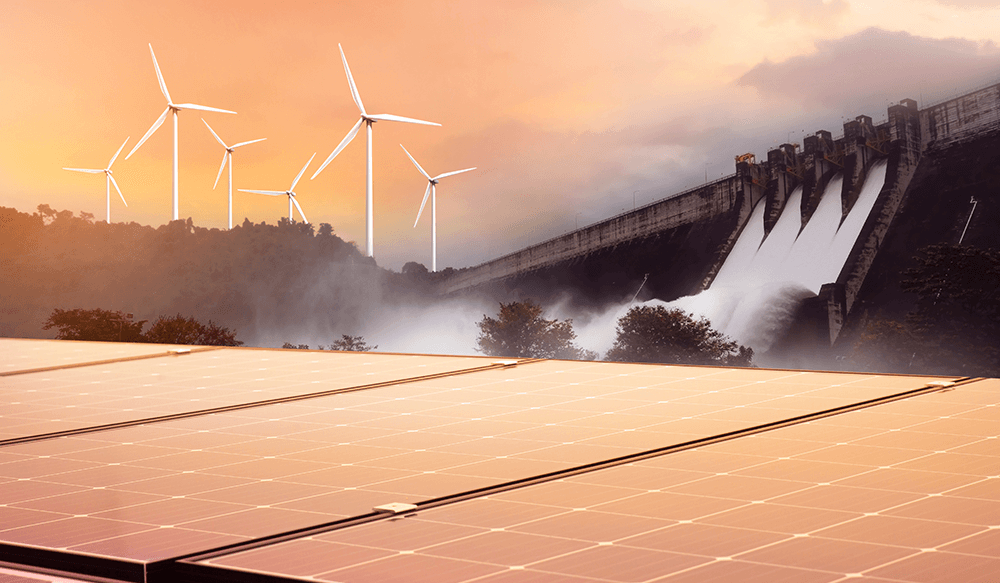

In [103]:
dashboard = pn.template.FastListTemplate(
    title='World usage of renewable energy',
    sidebar=[pn.pane.Markdown('# Renewable Energy'),
             pn.pane.Markdown('Renewable energy is energy derived from natural sources that are replenished at a higher rate than they are consumed. Sunlight and wind, for example, are such sources that are constantly being replenished. Renewable energy sources are plentiful and all around us.'),
             pn.pane.Markdown('## Settings'),
             year_slider,
             pn.pane.PNG(r'C:\Users\Дарья\Desktop\projects\renewables_dashboard\images\renewable-energy-mix-1.png', sizing_mode='scale_both'),
             ],
    main=[
        pn.Row(renewables_per_region_table.panel(width=300), renewables_per_continents_plot.panel(width=600), margin=(0,25)),
        pn.Row(renewablws_per_country_bar_plot.panel())
    ],
    accent_base_color='#D95D39',
    header_background='#D95D39',
    theme_toggle=False
    
)

dashboard.servable()

In [104]:
#panel serve renewable_dashboard.ipynb